In [6]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('nyc_taxi.csv')
df.head()

,timestamp,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820


In [3]:
df = pd.read_csv('nyc_taxi.csv',
                index_col='timestamp',
                parse_dates=True)
df.head()

,value
timestamp,
2014-07-01 00:00:00,10844
2014-07-01 00:30:00,8127
2014-07-01 01:00:00,6210
2014-07-01 01:30:00,4656
2014-07-01 02:00:00,3820


In [30]:
# plt.style.use('grayscale')
plt.style.use('default')
plt.rc("figure", figsize=(16, 5))

<Axes: xlabel='timestamp'>

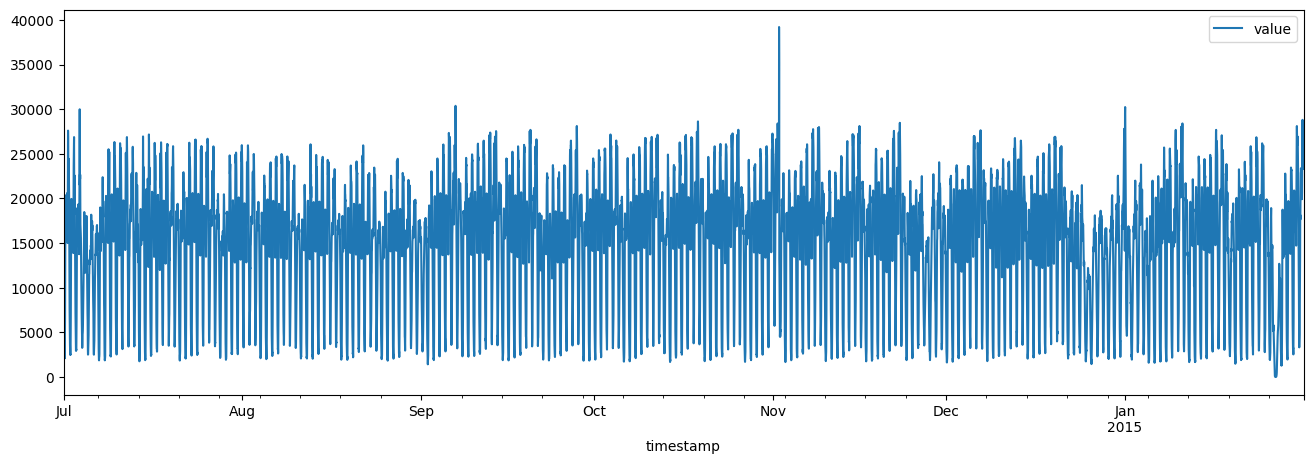

In [31]:
df.plot()

In [8]:
df.index.freq = '30min'

In [9]:
df.index

DatetimeIndex(['2014-07-01 00:00:00', '2014-07-01 00:30:00',
               '2014-07-01 01:00:00', '2014-07-01 01:30:00',
               '2014-07-01 02:00:00', '2014-07-01 02:30:00',
               '2014-07-01 03:00:00', '2014-07-01 03:30:00',
               '2014-07-01 04:00:00', '2014-07-01 04:30:00',
               ...
               '2015-01-31 19:00:00', '2015-01-31 19:30:00',
               '2015-01-31 20:00:00', '2015-01-31 20:30:00',
               '2015-01-31 21:00:00', '2015-01-31 21:30:00',
               '2015-01-31 22:00:00', '2015-01-31 22:30:00',
               '2015-01-31 23:00:00', '2015-01-31 23:30:00'],
              dtype='datetime64[ns]', name='timestamp', length=10320, freq='30min')

In [19]:
df_resample = df.resample('d').mean()
df_resample

,value
timestamp,
2014-07-01,15540.979167
2014-07-02,15284.166667
2014-07-03,14794.625000
2014-07-04,11511.770833
2014-07-05,11572.291667
...,...
2015-01-27,4834.541667
2015-01-28,12947.562500
2015-01-29,14686.145833


In [20]:
nyc_dates =  [
        "2014-11-01",
        "2014-11-27",
        "2014-12-25",
        "2015-01-01",
        "2015-01-27"
]

In [21]:
def plot_outliers(outliers, data, method='KNN', halignment='right', valignment='bottom', labels=False):
    
    fig, ax = plt.subplots(figsize=(10, 6))
        
    data.plot(ax=ax, alpha=0.6)
    
    # Plot outliers
    if labels:
        outliers.plot(ax=ax, style='rx', markersize=8, legend=False)
        
        # Add text labels for each outlier
        for idx, value in outliers['value'].items():
            ax.text(idx, value, f'{idx.date()}', 
                   horizontalalignment=halignment, 
                   verticalalignment=valignment)
    else:
        outliers.plot(ax=ax, style='rx', legend=False)
    
    ax.set_title(f'NYC Taxi - {method}')
    ax.set_xlabel('date')
    ax.set_ylabel('# of passengers')
    ax.legend(['nyc taxi', 'outliers'])
    
    plt.tight_layout()
    plt.show()

In [24]:
known_outliers = df_resample.loc[nyc_dates]

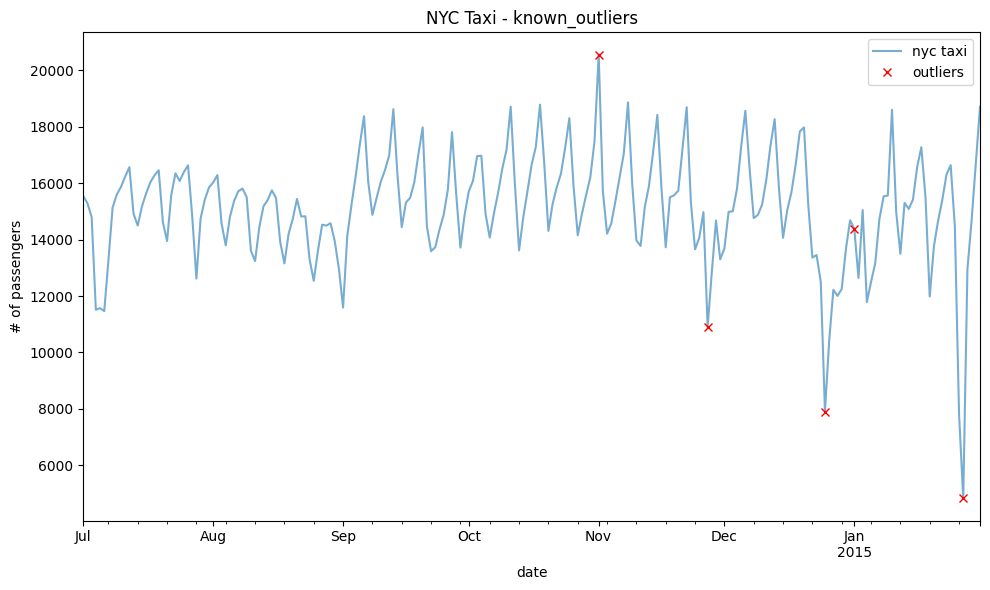

In [32]:
plot_outliers(known_outliers, df_resample, 'known_outliers')

In [26]:
import seaborn as sns

<Axes: ylabel='Count'>

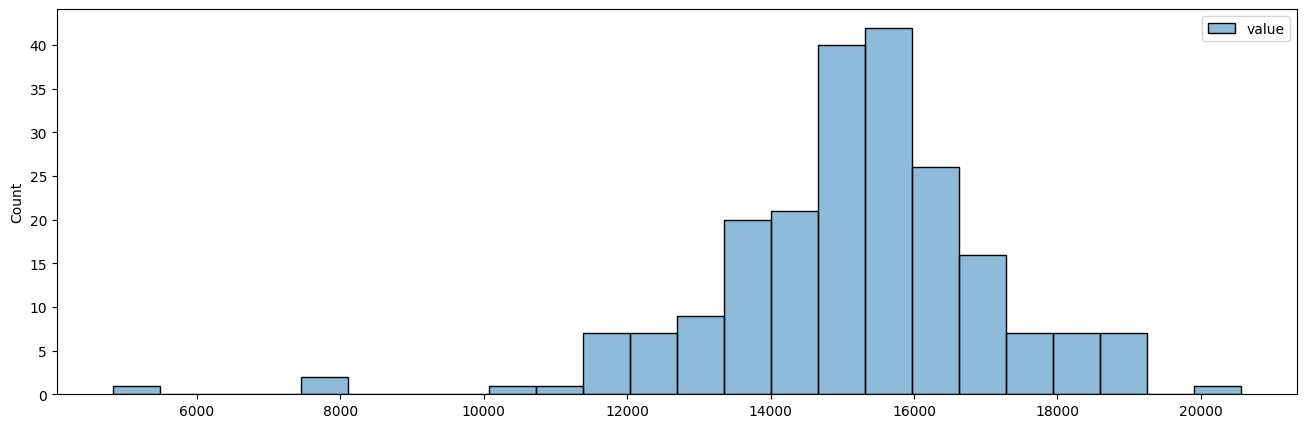

In [33]:
sns.histplot(df_resample)

<Axes: >

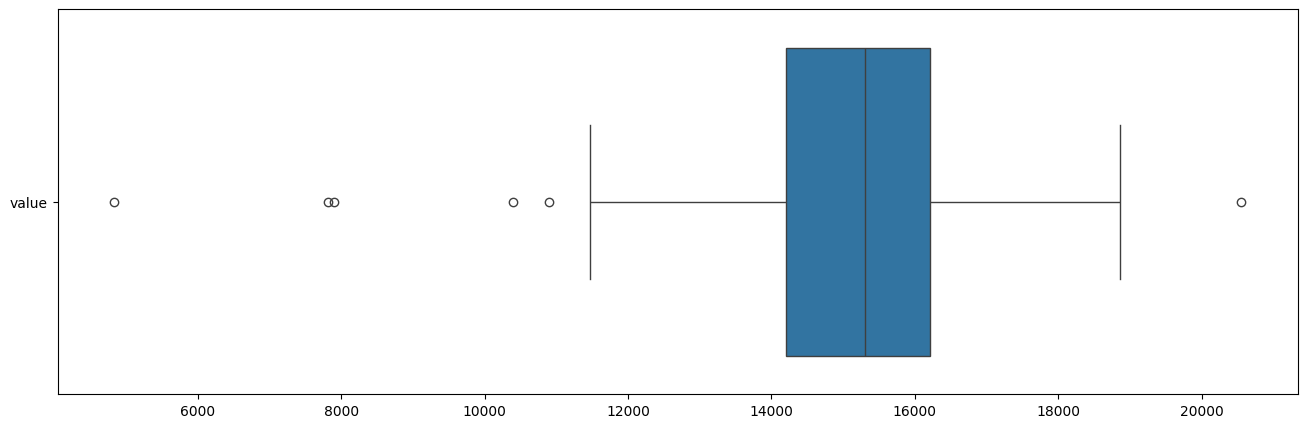

In [ ]:
sns.boxplot(df_resample, orient='h')

<Axes: >

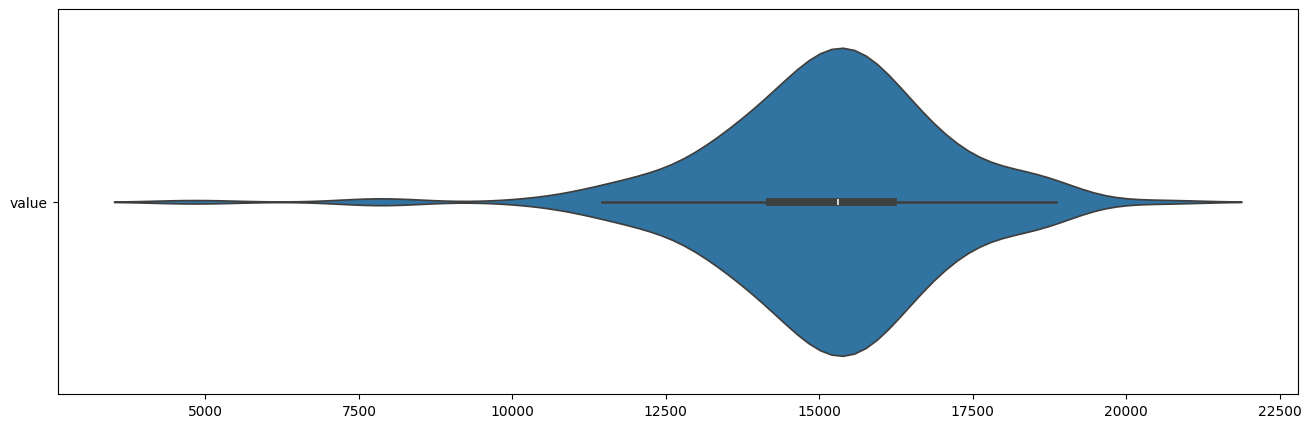

In [35]:
sns.violinplot(df_resample, orient='h')

In [36]:
import numpy as np

In [40]:
q1, q3 = np.percentile(df_resample, [25, 75])
IQR = q3 - q1
lower_fence = q1 - (1.5 * IQR)
upper_fence = q3 + (1.5 * IQR)


In [46]:
outliers = df_resample[(df_resample['value'] > upper_fence) | (df_resample['value'] < lower_fence)]

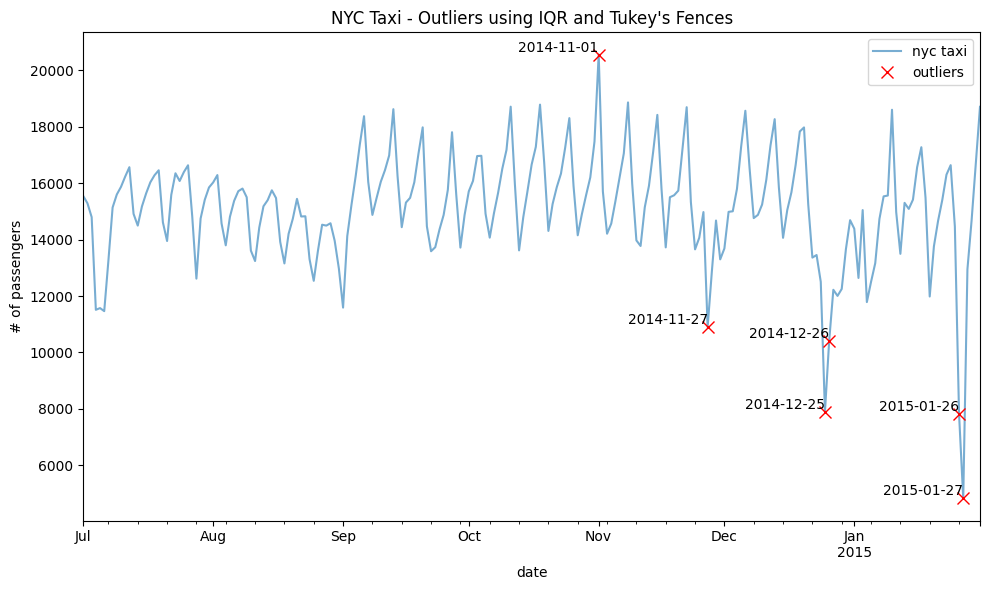

In [ ]:
plot_outliers(outliers,
              df_resample,
              "Outliers using IQR and Tukey's Fences",
              labels=True)

In [50]:
from pyod.models.knn import KNN
from pyod.models.iforest import IForest

In [52]:
iforest = IForest(contamination=0.03)

In [53]:
iforest.fit(df_resample)

IForest(behaviour='old', bootstrap=False, contamination=0.03,
    max_features=1.0, max_samples='auto', n_estimators=100, n_jobs=1,
    random_state=None, verbose=0)

In [57]:
iforest_pred = pd.Series(iforest.predict(df_resample), index=df_resample.index)

c:\Users\Benja\Documents\Projects\techcat\TechCatalyst_DE_2025_TWO\.venv\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(


In [64]:
iforest_outliers = iforest_pred[iforest_pred == 1]
iforest_outliers = df_resample.loc[iforest_outliers.index]

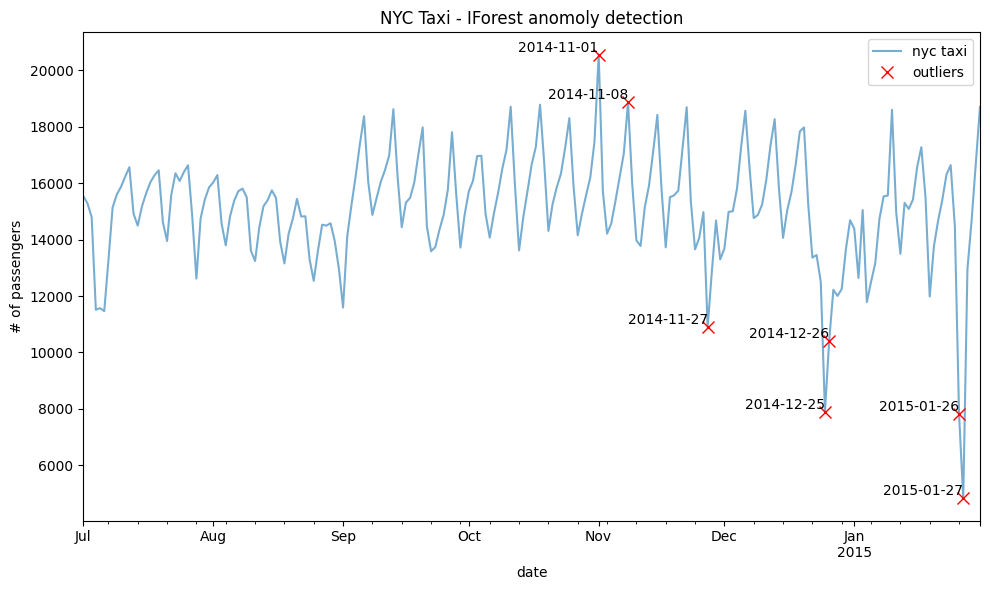

In [66]:
plot_outliers(
    iforest_outliers,
    df_resample,
    'IForest anomoly detection',
    labels=True
)